In [4]:
## COMBINE P-VALUES ##

/scratch/37960247/ipykernel_382599/778508868.py:27: RuntimeWarning: divide by zero encountered in log
  return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))
/scratch/37960247/ipykernel_382599/778508868.py:27: RuntimeWarning: divide by zero encountered in log10
  return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))


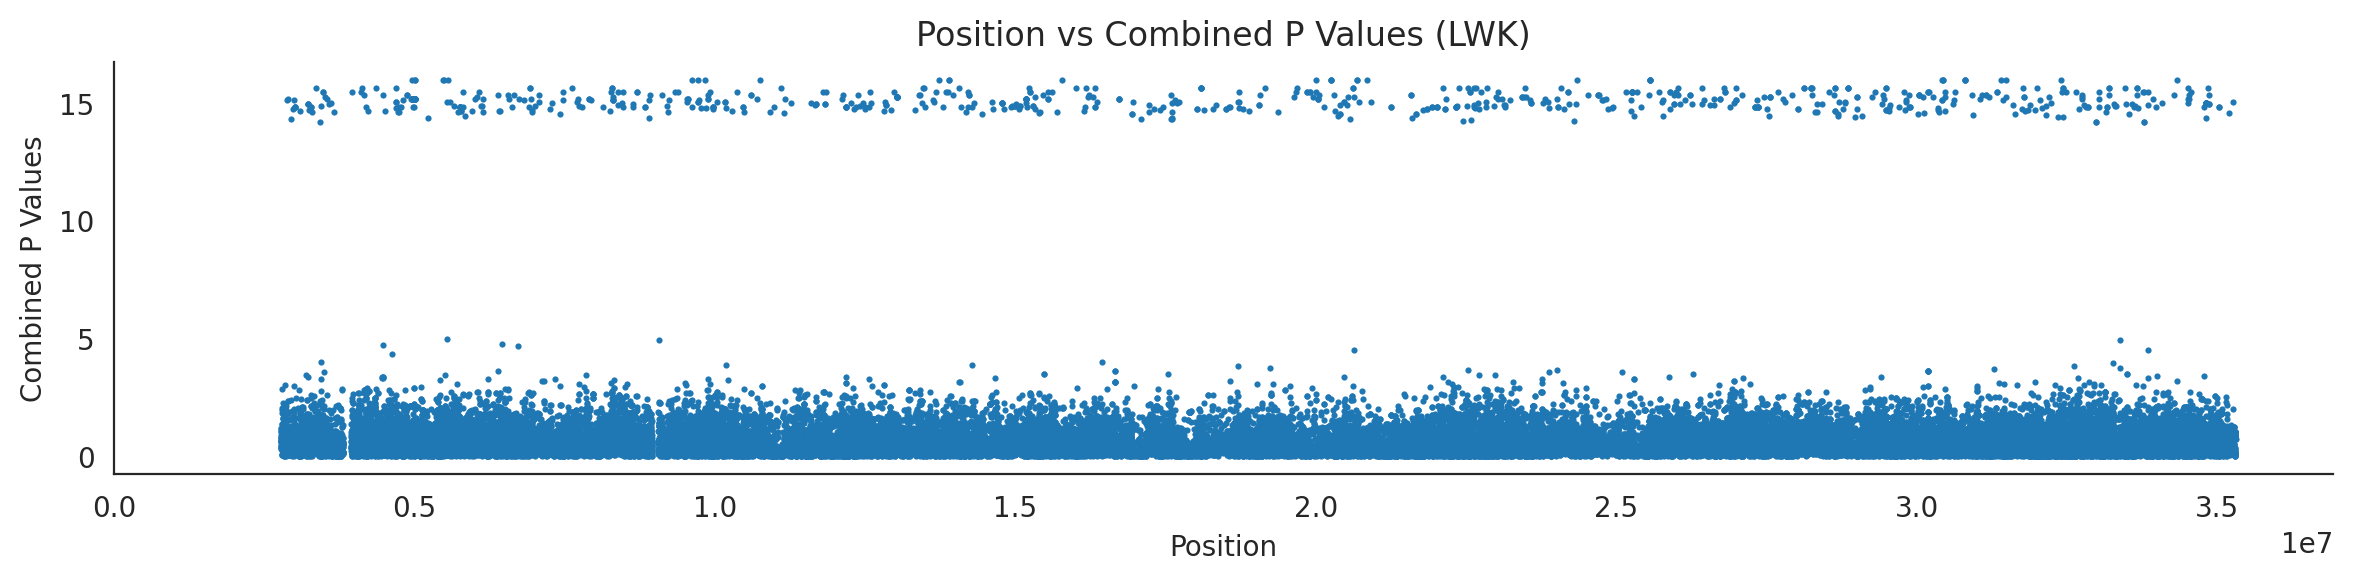

/scratch/37960247/ipykernel_382599/778508868.py:27: RuntimeWarning: divide by zero encountered in log
  return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))
/scratch/37960247/ipykernel_382599/778508868.py:27: RuntimeWarning: divide by zero encountered in log10
  return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))


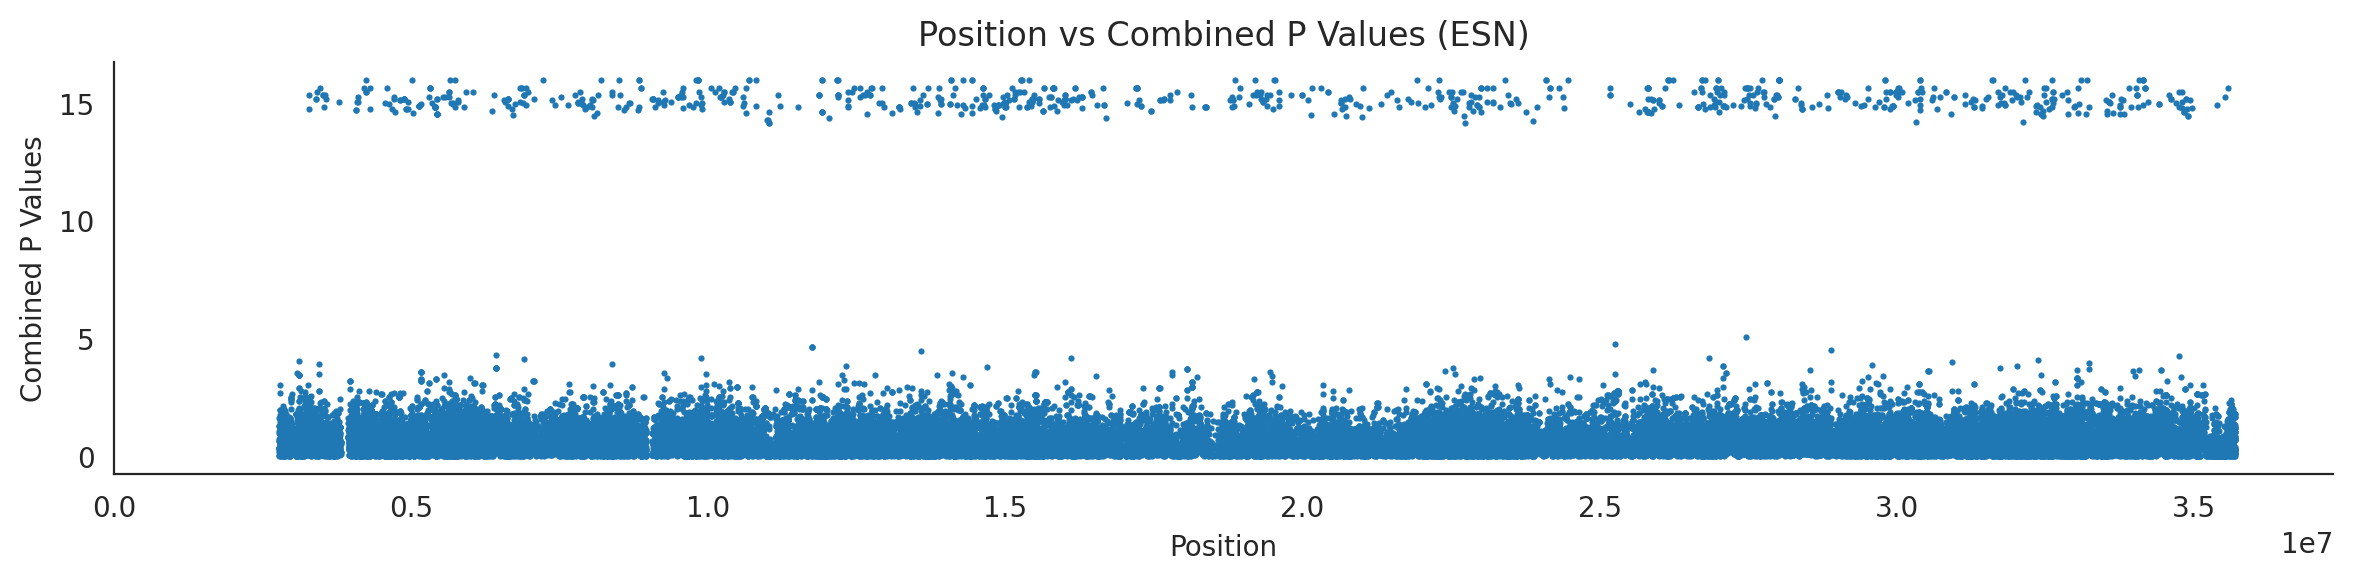

/scratch/37960247/ipykernel_382599/778508868.py:27: RuntimeWarning: divide by zero encountered in log
  return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))
/scratch/37960247/ipykernel_382599/778508868.py:27: RuntimeWarning: divide by zero encountered in log10
  return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))


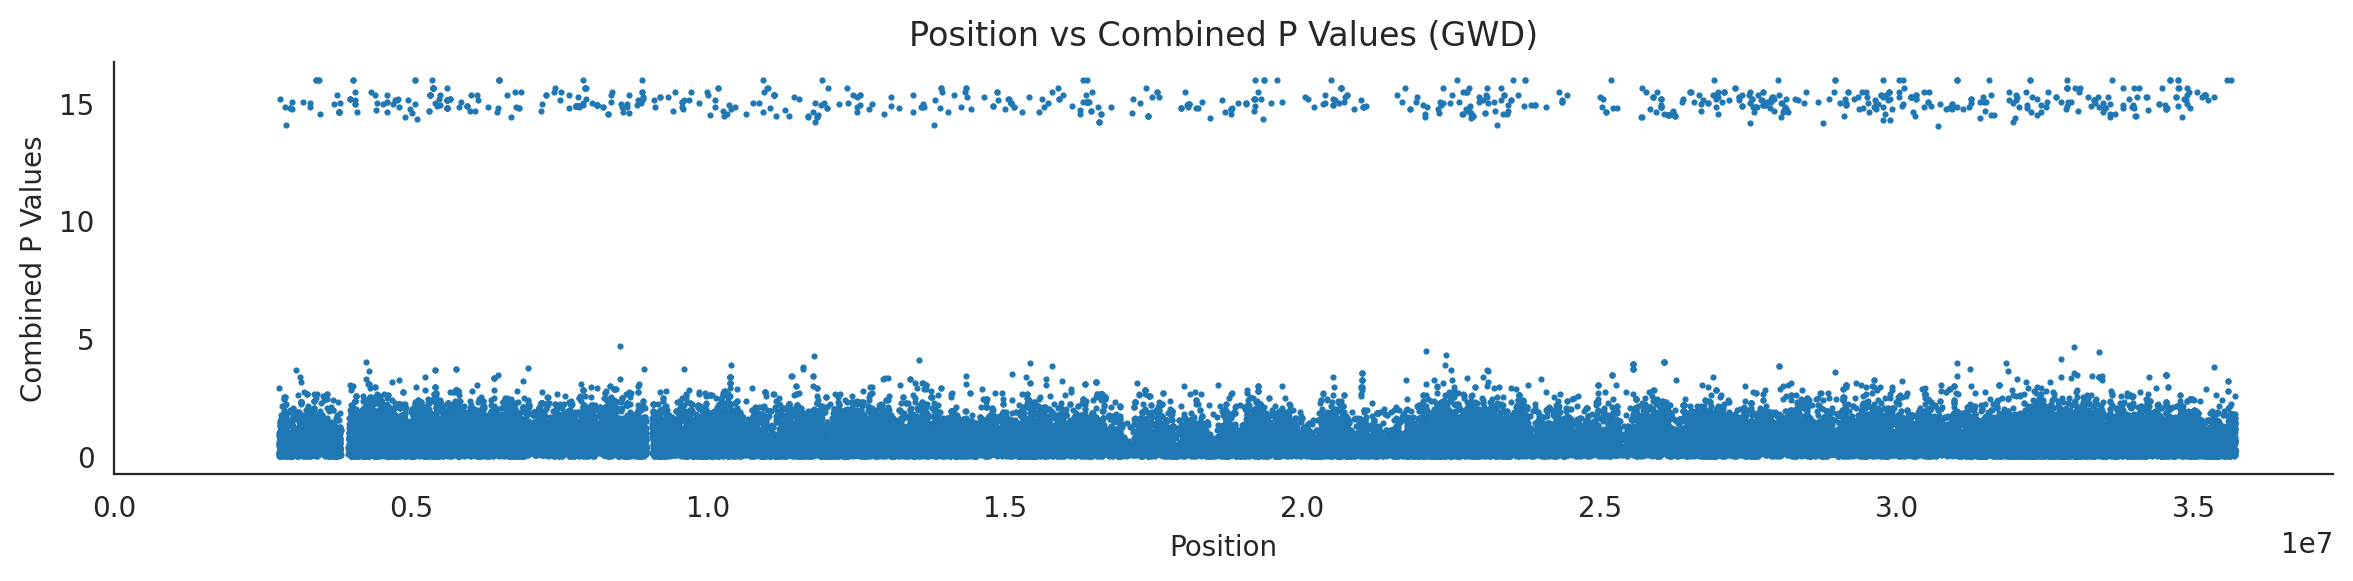

/scratch/37960247/ipykernel_382599/778508868.py:27: RuntimeWarning: divide by zero encountered in log
  return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))
/scratch/37960247/ipykernel_382599/778508868.py:27: RuntimeWarning: divide by zero encountered in log10
  return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))


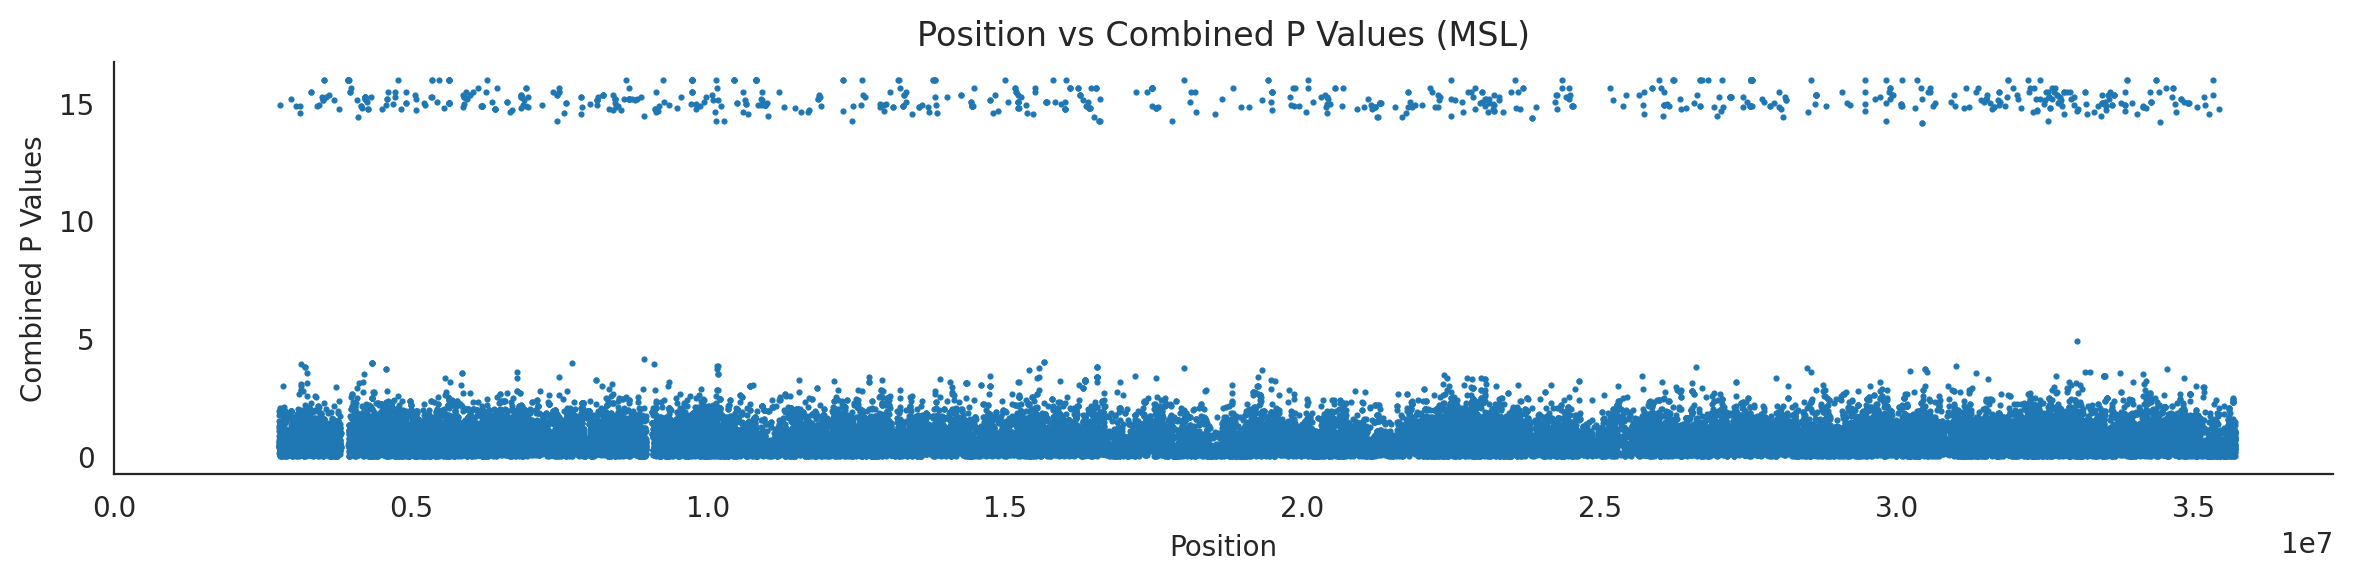

/scratch/37960247/ipykernel_382599/778508868.py:27: RuntimeWarning: divide by zero encountered in log
  return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))
/scratch/37960247/ipykernel_382599/778508868.py:27: RuntimeWarning: divide by zero encountered in log10
  return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))


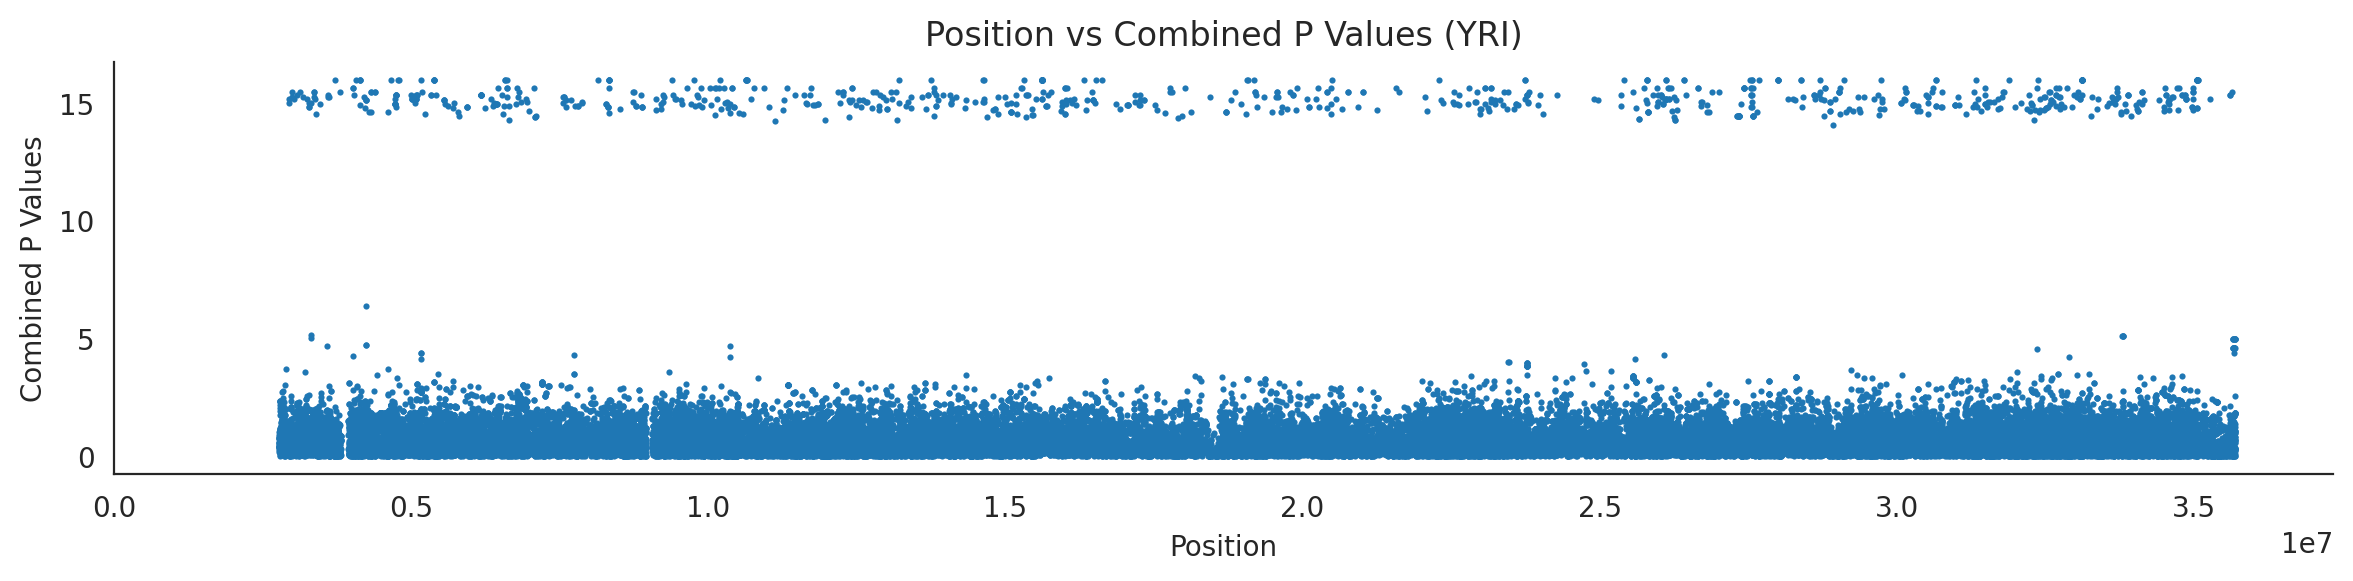

In [12]:
import pandas as pd
import numpy as np
from scipy.stats import chi2
import matplotlib.pyplot as plt
import seaborn as sns

import sys, os
import re
from collections import defaultdict
import numpy as np
import pandas as pd

%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')
from matplotlib.patches import Rectangle, Polygon
import seaborn as sns
sns.set_style('white')

import geneinfo as gi
gi.email('ariadna.saez@alum.esci.upf.edu')

def fisher_method_log10(pvalues):
    df = 2 * len(pvalues)
    return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))

# List of populations and their file paths
populations = {
    # africans
    'LWK': {
        'relate': "/home/ari/ari-intern/people/ari/ariadna-intern/steps/LWK/relate/run_relate/1000g_ppl_phased_haplotypes_selection.sele",
        'kasper': "/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_LWK_runstats.h5"
    },
    'ESN': {
        'relate': "/home/ari/ari-intern/people/ari/ariadna-intern/steps/ESN/relate/run_relate/1000g_ppl_phased_haplotypes_selection.sele",
        'kasper': "/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_ESN_runstats.h5"
    },
    'GWD': {
        'relate': "/home/ari/ari-intern/people/ari/ariadna-intern/steps/GWD/relate/run_relate/1000g_ppl_phased_haplotypes_selection.sele",
        'kasper': "/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_GWD_runstats.h5"
    },
    'MSL': {
        'relate': "/home/ari/ari-intern/people/ari/ariadna-intern/steps/MSL/relate/run_relate/1000g_ppl_phased_haplotypes_selection.sele",
        'kasper': "/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_MSL_runstats.h5"
    },
    'YRI': {
        'relate': "/home/ari/ari-intern/people/ari/ariadna-intern/steps/YRI/relate/run_relate/1000g_ppl_phased_haplotypes_selection.sele",
        'kasper': "/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_YRI_runstats.h5"
    }
}

for population, file_paths in populations.items():
    # Read files into DataFrames
    file1 = pd.read_csv(file_paths['relate'], sep=' ')
    file2 = pd.read_hdf(file_paths['kasper'])

    # Convert 'pos' column to integers in the second DataFrame
    file2['pos'] = file2['pos'].astype(int)

    # Merge the two DataFrames on the 'pos' column
    merged_df = pd.merge(file1[['pos', 'when_mutation_has_freq2']], file2[['pos', 'p']], on='pos', how='inner')

    # Apply -np.log10() function to the 'p' column (K p-value is not under logarithm)
    merged_df['p'] = -np.log10(merged_df['p'])

    # Change negative values to positive in the second and last columns
    merged_df[['when_mutation_has_freq2', 'p']] = merged_df[['when_mutation_has_freq2', 'p']].abs()

    combined_values = merged_df[['when_mutation_has_freq2', 'p']].values.tolist() # list of pairs

    # Convert data to DataFrame
    df = pd.DataFrame(merged_df)

    # Combine p-values
    combined_p_values = df[['when_mutation_has_freq2', 'p']].apply(fisher_method_log10, axis=1)

    # Create a new DataFrame with pos and combined p-values
    new_df = pd.DataFrame({'pos': df['pos'], 'combined_p_values': combined_p_values})

    # Plotting
    plt.figure(figsize=(12, 3))
    sns.scatterplot(data=new_df, x='pos', y='combined_p_values', linewidth=0, s=5)
    plt.xticks(np.arange(0, new_df['pos'].max()+1, 5000000))
    plt.xlabel('Position')
    plt.ylabel('Combined P Values')
    plt.title(f'Position vs Combined P Values ({population})')
    plt.tight_layout()
    sns.despine()
    plt.show()

In [16]:
# Dictionary to store subsets for each population
subsets = {}

# Threshold for p-value
threshold = 1e-6

# Iterate over populations
for population, file_paths in populations.items():
    # Filter new_df for the current population based on the threshold
    subset = new_df[new_df['combined_p_values'] <= -np.log10(threshold)]
    
    # Store the subset in the dictionary
    subsets[population] = subset

# Print a sample subset for each population
for population, subset in subsets.items():
    print(f"Subset dimensions for {population}: {subset.shape}")
    print(f"Subset for population {population}:")
    print(subset.head())
    print()



Subset dimensions for LWK: (50238, 2)
Subset for population LWK:
       pos  combined_p_values
0  2781584           1.012307
1  2781635           0.742142
3  2781927           0.771394
5  2783658           0.696813
6  2783897           0.252405

Subset dimensions for ESN: (50238, 2)
Subset for population ESN:
       pos  combined_p_values
0  2781584           1.012307
1  2781635           0.742142
3  2781927           0.771394
5  2783658           0.696813
6  2783897           0.252405

Subset dimensions for GWD: (50238, 2)
Subset for population GWD:
       pos  combined_p_values
0  2781584           1.012307
1  2781635           0.742142
3  2781927           0.771394
5  2783658           0.696813
6  2783897           0.252405

Subset dimensions for MSL: (50238, 2)
Subset for population MSL:
       pos  combined_p_values
0  2781584           1.012307
1  2781635           0.742142
3  2781927           0.771394
5  2783658           0.696813
6  2783897           0.252405

Subset dimension

/scratch/37960247/ipykernel_382599/2599026517.py:9: RuntimeWarning: divide by zero encountered in log
  return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))
/scratch/37960247/ipykernel_382599/2599026517.py:9: RuntimeWarning: divide by zero encountered in log10
  return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))


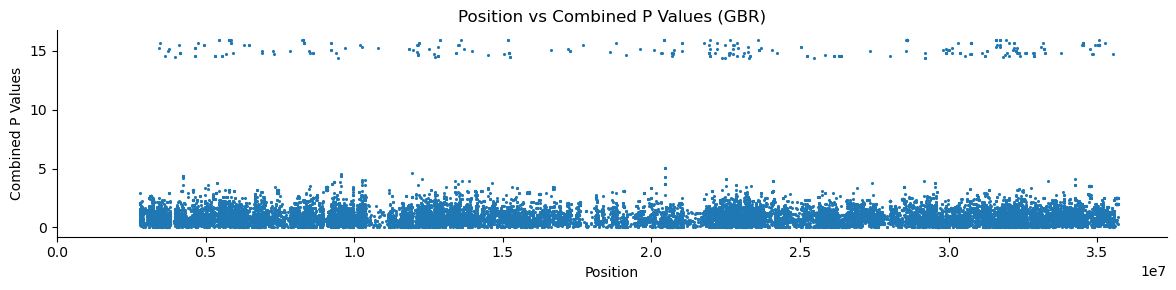

/scratch/37960247/ipykernel_382599/2599026517.py:9: RuntimeWarning: divide by zero encountered in log
  return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))
/scratch/37960247/ipykernel_382599/2599026517.py:9: RuntimeWarning: divide by zero encountered in log10
  return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))


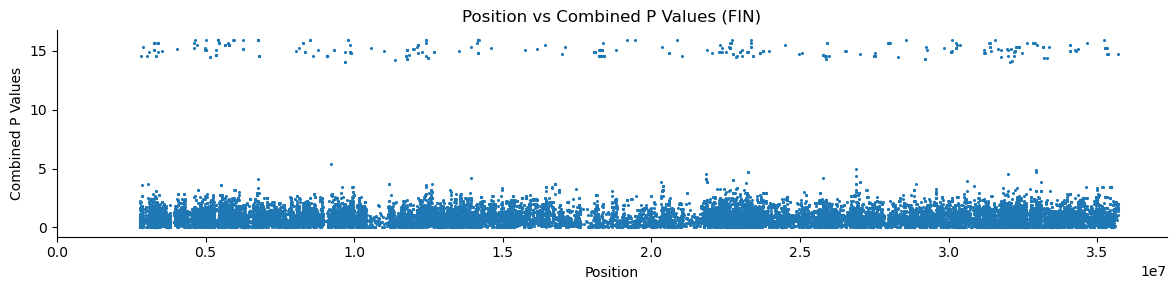

/scratch/37960247/ipykernel_382599/2599026517.py:9: RuntimeWarning: divide by zero encountered in log
  return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))
/scratch/37960247/ipykernel_382599/2599026517.py:9: RuntimeWarning: divide by zero encountered in log10
  return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))


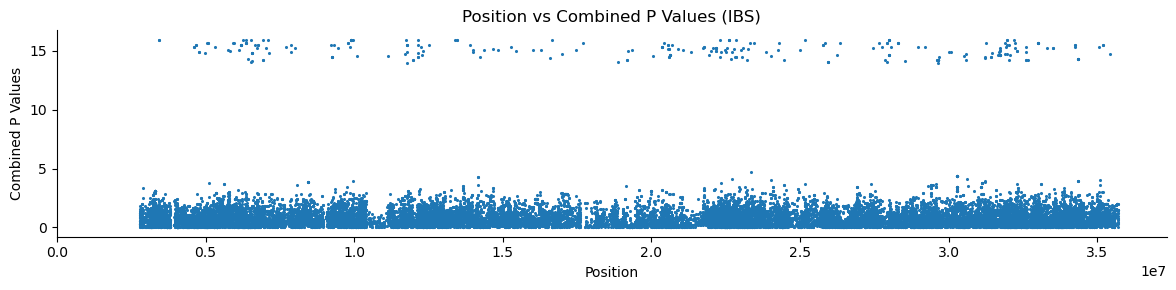

/scratch/37960247/ipykernel_382599/2599026517.py:9: RuntimeWarning: divide by zero encountered in log
  return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))
/scratch/37960247/ipykernel_382599/2599026517.py:9: RuntimeWarning: divide by zero encountered in log10
  return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))


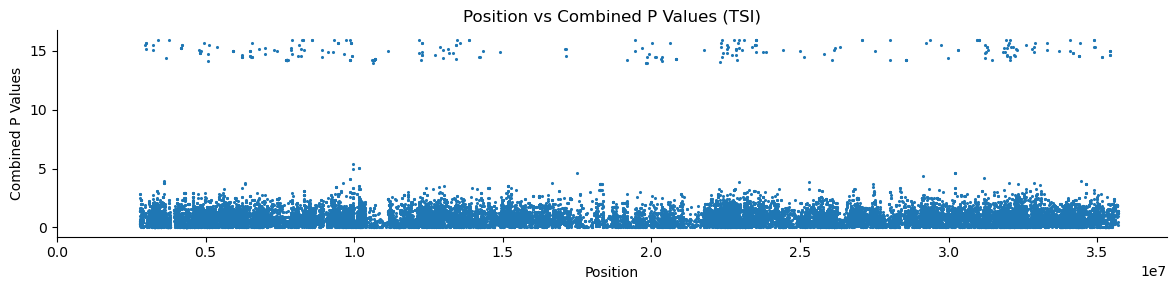

In [9]:
populations = {
    # europeans
    'GBR': {
        'relate': "/home/ari/ari-intern/people/ari/ariadna-intern/steps/GBR/relate/run_relate/1000g_ppl_phased_haplotypes_selection.sele",
        'kasper': "/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_GBR_runstats.h5"
    },
    'FIN': {
        'relate': "/home/ari/ari-intern/people/ari/ariadna-intern/steps/FIN/relate/run_relate/1000g_ppl_phased_haplotypes_selection.sele",
        'kasper': "/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_FIN_runstats.h5"
    },
    'IBS': {
        'relate': "/home/ari/ari-intern/people/ari/ariadna-intern/steps/IBS/relate/run_relate/1000g_ppl_phased_haplotypes_selection.sele",
        'kasper': "/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_IBS_runstats.h5"
    },
    'TSI': {
        'relate': "/home/ari/ari-intern/people/ari/ariadna-intern/steps/TSI/relate/run_relate/1000g_ppl_phased_haplotypes_selection.sele",
        'kasper': "/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_TSI_runstats.h5"
    }
}


for population, file_paths in populations.items():
    # Read files into DataFrames
    file1 = pd.read_csv(file_paths['relate'], sep=' ')
    file2 = pd.read_hdf(file_paths['kasper'])

    # Convert 'pos' column to integers in the second DataFrame
    file2['pos'] = file2['pos'].astype(int)

    # Merge the two DataFrames on the 'pos' column
    merged_df = pd.merge(file1[['pos', 'when_mutation_has_freq2']], file2[['pos', 'p']], on='pos', how='inner')

    # Apply -np.log10() function to the 'p' column (K p-value is not under logarithm)
    merged_df['p'] = -np.log10(merged_df['p'])

    # Change negative values to positive in the second and last columns
    merged_df[['when_mutation_has_freq2', 'p']] = merged_df[['when_mutation_has_freq2', 'p']].abs()

    combined_values = merged_df[['when_mutation_has_freq2', 'p']].values.tolist() # list of pairs

    # Convert data to DataFrame
    df = pd.DataFrame(merged_df)

    # Combine p-values
    combined_p_values = df[['when_mutation_has_freq2', 'p']].apply(fisher_method_log10, axis=1)

    # Create a new DataFrame with pos and combined p-values
    new_df = pd.DataFrame({'pos': df['pos'], 'combined_p_values': combined_p_values})

    # Plotting
    plt.figure(figsize=(12, 3))
    sns.scatterplot(data=new_df, x='pos', y='combined_p_values', linewidth=0, s=5)
    plt.xticks(np.arange(0, new_df['pos'].max()+1, 5000000))
    plt.xlabel('Position')
    plt.ylabel('Combined P Values')
    plt.title(f'Position vs Combined P Values ({population})')
    plt.tight_layout()
    sns.despine()
    plt.show()

/scratch/37960247/ipykernel_382599/2599026517.py:9: RuntimeWarning: divide by zero encountered in log
  return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))
/scratch/37960247/ipykernel_382599/2599026517.py:9: RuntimeWarning: divide by zero encountered in log10
  return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))


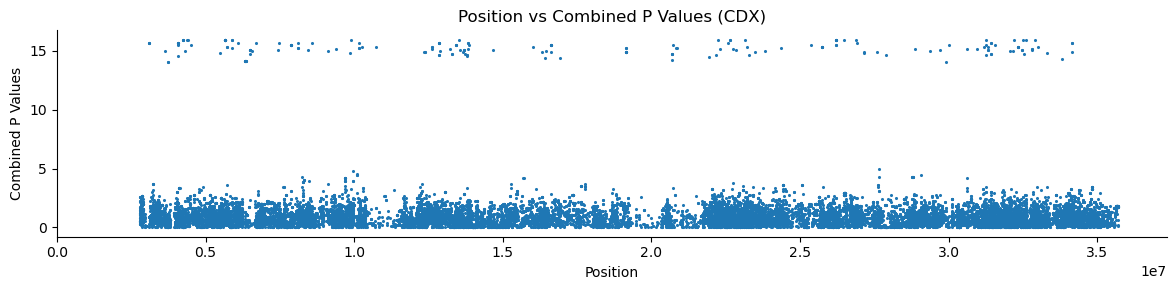

/scratch/37960247/ipykernel_382599/2599026517.py:9: RuntimeWarning: divide by zero encountered in log
  return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))
/scratch/37960247/ipykernel_382599/2599026517.py:9: RuntimeWarning: divide by zero encountered in log10
  return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))


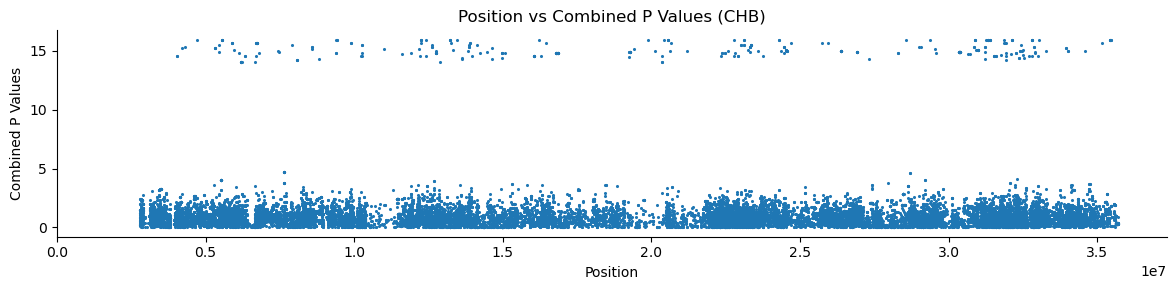

/scratch/37960247/ipykernel_382599/2599026517.py:9: RuntimeWarning: divide by zero encountered in log
  return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))
/scratch/37960247/ipykernel_382599/2599026517.py:9: RuntimeWarning: divide by zero encountered in log10
  return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))


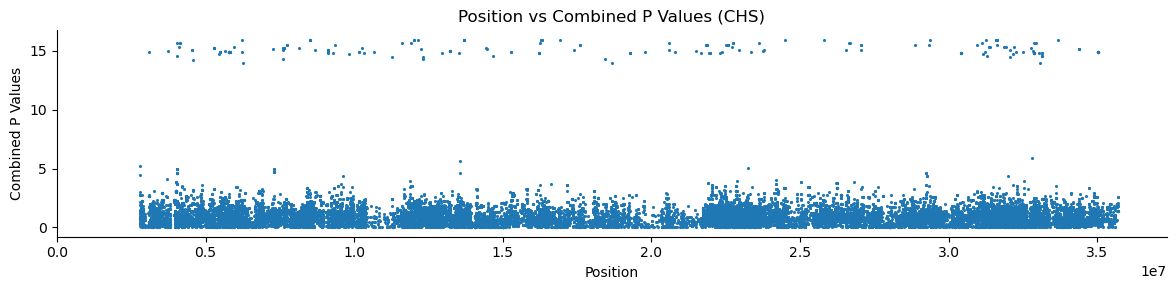

/scratch/37960247/ipykernel_382599/2599026517.py:9: RuntimeWarning: divide by zero encountered in log
  return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))
/scratch/37960247/ipykernel_382599/2599026517.py:9: RuntimeWarning: divide by zero encountered in log10
  return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))


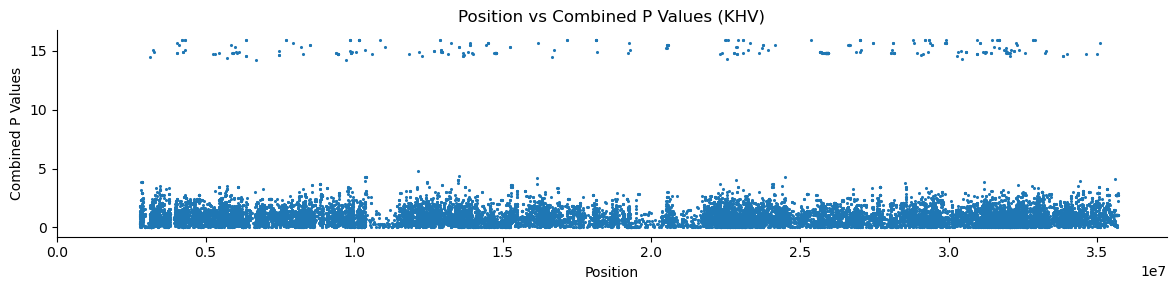

/scratch/37960247/ipykernel_382599/2599026517.py:9: RuntimeWarning: divide by zero encountered in log
  return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))
/scratch/37960247/ipykernel_382599/2599026517.py:9: RuntimeWarning: divide by zero encountered in log10
  return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))


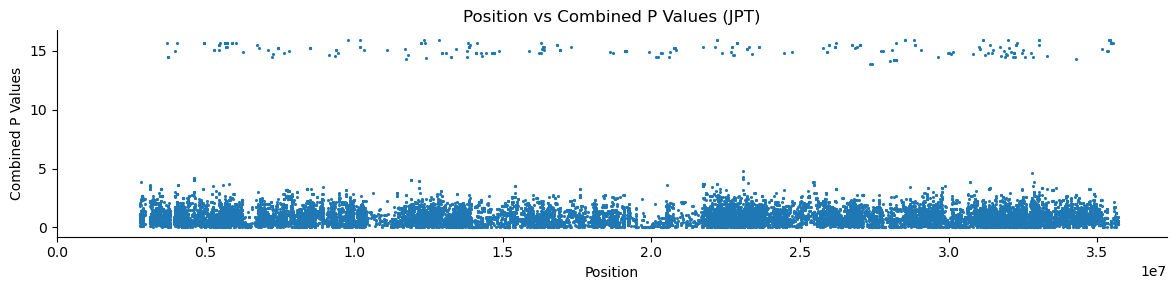

In [11]:
populations = {
    # asians
    'CDX': {
        'relate': "/home/ari/ari-intern/people/ari/ariadna-intern/steps/CDX/relate/run_relate/1000g_ppl_phased_haplotypes_selection.sele",
        'kasper': "/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_CDX_runstats.h5"
    },
    'CHB': {
        'relate': "/home/ari/ari-intern/people/ari/ariadna-intern/steps/CHB/relate/run_relate/1000g_ppl_phased_haplotypes_selection.sele",
        'kasper': "/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_CHB_runstats.h5"
    },
    'CHS': {
        'relate': "/home/ari/ari-intern/people/ari/ariadna-intern/steps/CHS/relate/run_relate/1000g_ppl_phased_haplotypes_selection.sele",
        'kasper': "/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_CHS_runstats.h5"
    },
    'KHV': {
        'relate': "/home/ari/ari-intern/people/ari/ariadna-intern/steps/KHV/relate/run_relate/1000g_ppl_phased_haplotypes_selection.sele",
        'kasper': "/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_KHV_runstats.h5"
    },
    'JPT': {
        'relate': "/home/ari/ari-intern/people/ari/ariadna-intern/steps/JPT/relate/run_relate/1000g_ppl_phased_haplotypes_selection.sele",
        'kasper': "/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_JPT_runstats.h5"
    }
}

# Iterate over populations
for population, file_paths in populations.items():
    # Read files into DataFrames
    file1 = pd.read_csv(file_paths['relate'], sep=' ')
    file2 = pd.read_hdf(file_paths['kasper'])

    # Convert 'pos' column to integers in the second DataFrame
    file2['pos'] = file2['pos'].astype(int)

    # Merge the two DataFrames on the 'pos' column
    merged_df = pd.merge(file1[['pos', 'when_mutation_has_freq2']], file2[['pos', 'p']], on='pos', how='inner')

    # Apply -np.log10() function to the 'p' column (K p-value is not under logarithm)
    merged_df['p'] = -np.log10(merged_df['p'])

    # Change negative values to positive in the second and last columns
    merged_df[['when_mutation_has_freq2', 'p']] = merged_df[['when_mutation_has_freq2', 'p']].abs()

    combined_values = merged_df[['when_mutation_has_freq2', 'p']].values.tolist() # list of pairs

    # Convert data to DataFrame
    df = pd.DataFrame(merged_df)

    # Combine p-values
    combined_p_values = df[['when_mutation_has_freq2', 'p']].apply(fisher_method_log10, axis=1)

    # Create a new DataFrame with pos and combined p-values
    new_df = pd.DataFrame({'pos': df['pos'], 'combined_p_values': combined_p_values})

    # Plotting
    plt.figure(figsize=(12, 3))
    sns.scatterplot(data=new_df, x='pos', y='combined_p_values', linewidth=0, s=5)
    plt.xticks(np.arange(0, new_df['pos'].max()+1, 5000000))
    plt.xlabel('Position')
    plt.ylabel('Combined P Values')
    plt.title(f'Position vs Combined P Values ({population})')
    plt.tight_layout()
    sns.despine()
    plt.show()